<a href="https://colab.research.google.com/github/OlegKuzmin1968/Oleg_Kuzmin/blob/main/Oleg_Kuzmin/XLT_Den_bin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Классификации методик лечения третьей стадии рака легких**

*НМИЦ профилактической медицины*



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Импорт библиотек

In [ ]:
# Загрузка файлов из облака
import gdown                       # Библиотека для работы с массивами данных
import numpy as np                 # Библиотека для обработки и анализа данных
import pandas as pd                # Библиотека для построения графиков
import matplotlib.pyplot as plt    # Команда для отображения графики в ячейках среды Google Colaboratory
%matplotlib inline
# Библиотека для построения графиков
import seaborn as sns
import math
import re
import os.path

from IPython.display import clear_output   # Для работы с датами
from datetime import datetime

#Используем для to_categoricall
from tensorflow.keras import utils

# Импорта библиотеки в рабочую область:         # Руководство по предварительной обработке данных https://skine.ru/articles/198719/
import sklearn                                  # Библиотека Scikit-learn для предварительной обработки данных
from sklearn.preprocessing import LabelEncoder  # Загружаем функцию предварительной обработки данных
from sklearn.preprocessing import OneHotEncoder # Функция кодирования категориальных признаков преобразует каждую категориальную функцию в двоичную функцию

## Загрузки для НС

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential # НС прямого распространения
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization # Основные слои
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization # Основные слои
from tensorflow.keras import utils # Утилиты для to_categorical
from tensorflow.keras.preprocessing import image # Для отрисовки изображения
from tensorflow.keras.optimizers import Adam, Adadelta # Алгоритмы оптимизации, для настройки скорости обучения
import numpy as np # Библиотека работы с массивами
import matplotlib.pyplot as plt # Отрисовка изображений
from PIL import Image # Отрисовка изображений
import pandas as pd # Библиотека pandas
from google.colab import files # Импорт файлов
from sklearn.preprocessing import LabelEncoder, StandardScaler # Функции для нормализации данных
from sklearn import preprocessing # Пакет предварительной обработки данных

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline

# Локальные функции

In [ ]:
def perevod_bin (list, str):
  ''' На вход подаем список вариантов одного из параметров (Молекулярный статус).
      # представлена возможность увеличения размерности потенциального увеличения числа вариантов через второй параметр.
      Функция создает словарь в котором каждому варианту (ключу) соответствует его бинарное число.
  '''
  x = len(list)
  #X = x * 2
  dist = {}
  for i in range (x): #(X):
    k = list[i]
    #print('Ключ', k)
    #z = bin(i)
    z = format(i, str) #  '06b')
    #print('Бинарное представление i ', z)
    dist[k] = z
  return dist



In [ ]:
# Пороговая функция активации
def porog (y_true):
  #print('Размер выходного массива по Х', y_true.shape)
  #q = y_pred
  for i in range(y_true.shape[1]):
    #print(i)
    if y_true[:,i] > 0.98:
      y_true[:,i] = 1
    elif y_true[:,i] < 0.98:
      y_true[:,i] = 0

  return y_true

# Загрузка датасета НМИЦ ХЛТ_Den


In [ ]:
# Укажим путь к файлу с данными на моем диске
way_2 = '/content/drive/MyDrive/Stag_2/ХЛТ_Ден.xlsx'

# Чтение данных из файла excel в pandas.DataFrame
NMIC_XLT = pd.read_excel(way_2)
print('Тип датафрейма NMIC_XLT', type(NMIC_XLT))
print('Размер датафрейма NMIC_XLT', NMIC_XLT.shape)
print('Число строк: ', NMIC_XLT.shape[0])
print('Число столбцов:', NMIC_XLT.shape[1])
print('='*50)
nan_cell_count = NMIC_XLT.isna().sum().sum()
nan_cell_count_proc = nan_cell_count*100/NMIC_XLT.size
print(f'общее количество пропусков во всей таблице: {nan_cell_count}, {round(nan_cell_count_proc, 2)}%')
NMIC_XLT.head(3)

Тип датафрейма NMIC_XLT <class 'pandas.core.frame.DataFrame'>
Размер датафрейма NMIC_XLT (147456, 19)
Число строк:  147456
Число столбцов: 19
общее количество пропусков во всей таблице: 0, 0.0%


,номер_ответа,Стадия,Гистология,ECOG,Возраст,Пол,Молекулярный статус (только для неплоскоклеточного рака),PD-L1 статус,Статус курения,Относительные противопоказания к ЛТ,Предпочтение пациента по ответу на терапию,Ответ эксперта (Ден),Вариант ХТ,Альтернативный выбор ХТ (как компонента ХЛТ),"Поставьте галочку, если уверены на 100%",Если 75%,Если 50%,"Альтернатива, если 50% - обязательно",Комментарий
0,1,IIIаI,плоскоклеточный,0-1,До 70,Мужской,нет мутаций,не исследовался,В настоящее время,да,результативность лечения,одномоментная ХЛТ,Этопозид цисплатин/карбоплатин Дурвалумаб,паклитаксел+карбоплатин,True,False,False,0,Необходима консультация хирурга на предмет воз...
1,2,IIIб,плоскоклеточный,0-1,До 70,Мужской,нет мутаций,не исследовался,В настоящее время,да,результативность лечения,одномоментная ХЛТ,Этопозид цисплатин,паклитаксел+карбоплатин,True,False,False,0,0
2,3,IIIаI,неплоскоклеточный,0-1,До 70,Мужской,нет мутаций,не исследовался,В настоящее время,да,результативность лечения,одномоментная ХЛТ,пеметрексед+цисплатин,паклитаксел+карбоплатин,True,False,False,0,0


## Информация по колонкам NMIC_XLT

In [ ]:
# Количество уникальных значений в каждом столбце
print('Кол-во уникальных значений в каждом столбце DF')
NMIC_XLT.nunique()

Кол-во уникальных значений в каждом столбце DF


номер_ответа                                                72
Стадия                                                       2
Гистология                                                   3
ECOG                                                         3
Возраст                                                      2
Пол                                                          2
Молекулярный статус (только для неплоскоклеточного рака)    16
PD-L1 статус                                                 4
Статус курения                                               4
Относительные противопоказания к ЛТ                          2
Предпочтение пациента по ответу на терапию                   2
Ответ эксперта (Ден)                                         3
Вариант ХТ                                                   5
Альтернативный выбор ХТ (как компонента ХЛТ)                 4
Поставьте галочку, если уверены на 100%                      2
Если 75%                                               

In [ ]:
# Список всех столбцов DF
nmic_xlt_list = NMIC_XLT.columns.tolist()
print('Кол-во колонок в DF', len(nmic_xlt_list))
nmic_xlt_list

Кол-во колонок в DF 19


['номер_ответа',
 'Стадия',
 'Гистология',
 'ECOG',
 'Возраст',
 'Пол',
 'Молекулярный статус (только для неплоскоклеточного рака)',
 'PD-L1 статус',
 'Статус курения',
 'Относительные противопоказания к ЛТ',
 'Предпочтение пациента по ответу на терапию',
 'Ответ эксперта (Ден)',
 'Вариант ХТ',
 'Альтернативный выбор ХТ (как компонента ХЛТ)',
 'Поставьте галочку, если уверены на 100%',
 'Если 75%',
 'Если 50%',
 'Альтернатива, если 50% - обязательно',
 'Комментарий']

# Обработка входного DS

## Создадим столбцы для записи соответствующих цифровыз значений DS

In [ ]:
df1_cat_colnames = ['No',
 'stadia',
 'gistologia',
 'ecog',
 'age',
 'gender',
 'ms*',
 'pd',
 'smoke',
 'no_LT',
 'expectation',
 'expert',
 'variant_XT',
 'alt_XT',
 'sure100',
 'sure75',
 'sure50',
 'alt_50',
 'comment' ]

print(f'df1_cat_colnames: {len(df1_cat_colnames)} : {df1_cat_colnames}')
type(df1_cat_colnames)

df1_cat_colnames: 19 : ['No', 'stadia', 'gistologia', 'ecog', 'age', 'gender', 'ms*', 'pd', 'smoke', 'no_LT', 'expectation', 'expert', 'variant_XT', 'alt_XT', 'sure100', 'sure75', 'sure50', 'alt_50', 'comment']


list

## Функция перевода значения ячейки df в цыфровую форму

In [ ]:
# Смотрим содержимое одного из столбцов
c = nmic_xlt_list[8]
a = list(NMIC_XLT[c].unique()) # создадим список уникальных значений
a

[' В настоящее время',
 ' Курение в прошлом (бросил более 1 месяца до 1 года)',
 ' Курение в прошлом (бросил более 1 года)',
 ' Никогда не курил']

In [ ]:
def perevod (NMIC_XLT,nmic_xlt_list, df1_cat_colnames):
  ''' вход   сам DF          NMIC_XLT
             список столбцов nmic_xlt_list
             список столбцов оцыфрованного DF df1_cat_colnames

  '''
  i_arr  = np.zeros(NMIC_XLT.shape[0], dtype=int) # служебная копия одного столбца
  i_arr2 = np.zeros(NMIC_XLT.shape[0], dtype=int) # служебная копия одного столбца
  list_dist = []

  for inx in range (1, len(nmic_xlt_list)):           # цыкл по списку столбцов DF
    c = nmic_xlt_list[inx]
    print('c',c)
    a = list(NMIC_XLT[c].unique())  # список уникальных значений в указанном столбце датасета df_global_com
    #print('Количество вариантов "Статус курения" в датасете NMIC_XLT -', len(a), type(a))
    #print(a)
    print('len(a)',len(a))
    label_encoder = LabelEncoder()                    # загружаем кодировщик меток
    integer_encoded = label_encoder.fit_transform(a)  # используем функцию целочисленного кодирования .fit_transform(),
    integer_encoded = integer_encoded.tolist()        # переводим массив np в список
    #print(type(integer_encoded))
    #print(integer_encoded)                           # целочисленный код
    a_dist = dict(zip(a, integer_encoded))            # собираем из двух списков словарь
    print('a_dist', a_dist)
    list_dist.append(a_dist)
    col_name = nmic_xlt_list[inx]
    #print(col_name)

    #print(f"inx: {inx}, col_name: '{col_name}', col_name2: '{col_name2}'")
    # NMIC_XLT[col_name2] = pd.Series(dtype='int')     # создаем в DF новый столбец с текущим именем
    row_inx = 0
    for elem_val in NMIC_XLT[col_name]:  # цыкл по строкам текущего столбца
      #print(elem_val)
      digi_code = a_dist[elem_val]
      #digi_code = getSmokingStatusCode(elem_val)
      i_arr[row_inx] = digi_code
      row_inx += 1
      #print('row_inx', row_inx)
      #print(i_arr.shape)
      #print(i_arr[-1])

    i_arr2 = utils.to_categorical(i_arr, len(a))
    ohe_lst2 = i_arr2.astype(int).tolist()
    #print(type(ohe_lst2))
    #col_name2 = df1_cat_colnames[inx]
    #print('col_name2', col_name2)
    #c = df1_cat_colnames[inx]
    #NMIC_XLT = NMIC_XLT.assign(col_name2 = ohe_lst2)

    NMIC_XLT = NMIC_XLT.assign( rar = ohe_lst2)
    NMIC_XLT.rename (columns={'rar': df1_cat_colnames[inx]}, inplace=True)
    print(f'размеры датафрейма NMIC_XLT: {NMIC_XLT.shape}')
    #NMIC_XLT.head(3)
    del i_arr2
    del ohe_lst2

  print(f'размеры датафрейма NMIC_XLT: {NMIC_XLT.shape}')

  return NMIC_XLT, list_dist
  #return NMIC_XLT

In [ ]:
NMIC_XLT_BIN, list_dist = perevod (NMIC_XLT,nmic_xlt_list, df1_cat_colnames)

c Стадия
len(a) 2
a_dist {'IIIаI': 0, 'IIIб': 1}
размеры датафрейма NMIC_XLT: (147456, 20)
c Гистология
len(a) 3
a_dist {' плоскоклеточный': 2, ' неплоскоклеточный': 1, ' мелкоклеточный': 0}
размеры датафрейма NMIC_XLT: (147456, 21)
c ECOG
len(a) 3
a_dist {'  0-1': 0, 2: 2, ' 3+': 1}
размеры датафрейма NMIC_XLT: (147456, 22)
c Возраст
len(a) 2
a_dist {' До 70': 1, ' >70': 0}
размеры датафрейма NMIC_XLT: (147456, 23)
c Пол
len(a) 2
a_dist {'Мужской': 1, 'Женский': 0}
размеры датафрейма NMIC_XLT: (147456, 24)
c Молекулярный статус (только для неплоскоклеточного рака)
len(a) 16
a_dist {' нет мутаций': 15, ' не исследовались': 14, ' EGFR ex19': 5, ' EGFR ex21': 7, ' EGFR ex18': 4, ' EGFR ex20': 6, ' EGFR T790M': 3, ' EGFR (G719X, L816Q, S768I)': 2, ' ALK': 0, ' ROS1': 13, ' BRAF': 1, ' RET': 12, ' MET 14ex': 10, ' HER2': 8, ' KRAS G12C': 9, ' NTRK': 11}
размеры датафрейма NMIC_XLT: (147456, 25)
c PD-L1 статус
len(a) 4
a_dist {' не исследовался': 1, 0.01: 3, ' 1–49\xa0%': 0, ' ≥50\xa0%': 2}

In [ ]:
# Смотрим параметры получившегося df
print('Параметры получившегося df', type(NMIC_XLT_BIN), NMIC_XLT_BIN.shape)
NMIC_XLT_BIN.head(3)


Параметры получившегося df <class 'pandas.core.frame.DataFrame'> (147456, 37)


,номер_ответа,Стадия,Гистология,ECOG,Возраст,Пол,Молекулярный статус (только для неплоскоклеточного рака),PD-L1 статус,Статус курения,Относительные противопоказания к ЛТ,...,no_LT,expectation,expert,variant_XT,alt_XT,sure100,sure75,sure50,alt_50,comment
0,1,IIIаI,плоскоклеточный,0-1,До 70,Мужской,нет мутаций,не исследовался,В настоящее время,да,...,"[1, 0]","[1, 0]","[0, 1, 0]","[0, 0, 1, 0, 0]","[0, 0, 1, 0]","[0, 1]","[1, 0]","[1, 0]","[1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0]"
1,2,IIIб,плоскоклеточный,0-1,До 70,Мужской,нет мутаций,не исследовался,В настоящее время,да,...,"[1, 0]","[1, 0]","[0, 1, 0]","[0, 1, 0, 0, 0]","[0, 0, 1, 0]","[0, 1]","[1, 0]","[1, 0]","[1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,3,IIIаI,неплоскоклеточный,0-1,До 70,Мужской,нет мутаций,не исследовался,В настоящее время,да,...,"[1, 0]","[1, 0]","[0, 1, 0]","[0, 0, 0, 1, 0]","[0, 0, 1, 0]","[0, 1]","[1, 0]","[1, 0]","[1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
print('Количество словарей в списке',len(list_dist))
list_dist[-8]

Количество словарей в списке 18


{'одномоментная ХЛТ': 1,
 'последовательная ХЛТ': 2,
 'Симптоматическая терапия': 0}

In [ ]:
# Список всех столбцов DF
nmic_xlt_bin = NMIC_XLT_BIN.columns.tolist()
print('Кол-во колонок в DF', len(nmic_xlt_bin))
nmic_xlt_bin

Кол-во колонок в DF 37


['номер_ответа',
 'Стадия',
 'Гистология',
 'ECOG',
 'Возраст',
 'Пол',
 'Молекулярный статус (только для неплоскоклеточного рака)',
 'PD-L1 статус',
 'Статус курения',
 'Относительные противопоказания к ЛТ',
 'Предпочтение пациента по ответу на терапию',
 'Ответ эксперта (Ден)',
 'Вариант ХТ',
 'Альтернативный выбор ХТ (как компонента ХЛТ)',
 'Поставьте галочку, если уверены на 100%',
 'Если 75%',
 'Если 50%',
 'Альтернатива, если 50% - обязательно',
 'Комментарий',
 'stadia',
 'gistologia',
 'ecog',
 'age',
 'gender',
 'ms*',
 'pd',
 'smoke',
 'no_LT',
 'expectation',
 'expert',
 'variant_XT',
 'alt_XT',
 'sure100',
 'sure75',
 'sure50',
 'alt_50',
 'comment']

# Запишем df_global_bin на disk

In [ ]:
NMIC_XLT_BIN.to_pickle ('/content/drive/MyDrive/Stag_2/df_xlt_den.pkl')  # запишем df с именем df_xlt_lak на disk

In [ ]:
NMIC_XLT_BIN = pd.read_pickle ('/content/drive/MyDrive/Stag_2/df_xlt_den.pkl')     # читаем df_xlt_lak с diskа в NB
print('NMIC_XLT_BIN', NMIC_XLT_BIN.shape, type(NMIC_XLT_BIN))

NMIC_XLT_BIN (147456, 37) <class 'pandas.core.frame.DataFrame'>


# Формирование вектора x и y

## Возьмем из DF NMIC_XLT_BIN только цифровые данные

In [ ]:
BIN_Den = NMIC_XLT_BIN[NMIC_XLT_BIN.columns[19:]]
print('BIN_Den.shape', BIN_Den.shape)
BIN_Den.head(3)

BIN_Den.shape (147456, 18)


,stadia,gistologia,ecog,age,gender,ms*,pd,smoke,no_LT,expectation,expert,variant_XT,alt_XT,sure100,sure75,sure50,alt_50,comment
0,"[1, 0]","[0, 0, 1]","[1, 0, 0]","[0, 1]","[0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 1, 0, 0]","[1, 0, 0, 0]","[1, 0]","[1, 0]","[0, 1, 0]","[0, 0, 1, 0, 0]","[0, 0, 1, 0]","[0, 1]","[1, 0]","[1, 0]","[1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0]"
1,"[0, 1]","[0, 0, 1]","[1, 0, 0]","[0, 1]","[0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 1, 0, 0]","[1, 0, 0, 0]","[1, 0]","[1, 0]","[0, 1, 0]","[0, 1, 0, 0, 0]","[0, 0, 1, 0]","[0, 1]","[1, 0]","[1, 0]","[1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"[1, 0]","[0, 1, 0]","[1, 0, 0]","[0, 1]","[0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 1, 0, 0]","[1, 0, 0, 0]","[1, 0]","[1, 0]","[0, 1, 0]","[0, 0, 0, 1, 0]","[0, 0, 1, 0]","[0, 1]","[1, 0]","[1, 0]","[1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0]"


### x_df

Возьмем первых 10-ть столбцов df для создания x_train

In [ ]:
x_df = BIN_Den[BIN_Den.columns[0:10]] # берем первых 10 столбцов ()
print('Размерность df для формирования x_train', x_df.shape)
x_df

Размерность df для формирования x_train (147456, 10)


,stadia,gistologia,ecog,age,gender,ms*,pd,smoke,no_LT,expectation
0,"[1, 0]","[0, 0, 1]","[1, 0, 0]","[0, 1]","[0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 1, 0, 0]","[1, 0, 0, 0]","[1, 0]","[1, 0]"
1,"[0, 1]","[0, 0, 1]","[1, 0, 0]","[0, 1]","[0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 1, 0, 0]","[1, 0, 0, 0]","[1, 0]","[1, 0]"
2,"[1, 0]","[0, 1, 0]","[1, 0, 0]","[0, 1]","[0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 1, 0, 0]","[1, 0, 0, 0]","[1, 0]","[1, 0]"
3,"[0, 1]","[0, 1, 0]","[1, 0, 0]","[0, 1]","[0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 1, 0, 0]","[1, 0, 0, 0]","[1, 0]","[1, 0]"
4,"[1, 0]","[1, 0, 0]","[1, 0, 0]","[0, 1]","[0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 1, 0, 0]","[1, 0, 0, 0]","[1, 0]","[1, 0]"
...,...,...,...,...,...,...,...,...,...,...
147451,"[0, 1]","[0, 0, 1]","[0, 1, 0]","[1, 0]","[1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0, 0, 1, 0]","[0, 0, 0, 1]","[0, 1]","[0, 1]"
147452,"[1, 0]","[0, 1, 0]","[0, 1, 0]","[1, 0]","[1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0, 0, 1, 0]","[0, 0, 0, 1]","[0, 1]","[0, 1]"
147453,"[0, 1]","[0, 1, 0]","[0, 1, 0]","[1, 0]","[1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0, 0, 1, 0]","[0, 0, 0, 1]","[0, 1]","[0, 1]"
147454,"[1, 0]","[1, 0, 0]","[0, 1, 0]","[1, 0]","[1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0, 0, 1, 0]","[0, 0, 0, 1]","[0, 1]","[0, 1]"


In [ ]:
# Получим список столбцов
x_list = x_df.columns.tolist()
x_list

['stadia',
 'gistologia',
 'ecog',
 'age',
 'gender',
 'ms*',
 'pd',
 'smoke',
 'no_LT',
 'expectation']

In [ ]:
# Создадим заготовку для записи в него единого вектора "x". Это будет df из одного столбца с количеством строк как у исходного x_df
vektor_x = x_df.iloc[:,[0]]            # копия "0"-го столбца x_df
print(type(vektor_x))
vektor_x.rename(columns={'stadia':'vektor'}, inplace=True)  # переименуем столбец
print(vektor_x.shape)
vektor_x

<class 'pandas.core.frame.DataFrame'>
(147456, 1)


<ipython-input-23-ceb4bd335e1a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vektor_x.rename(columns={'stadia':'vektor'}, inplace=True)  # переименуем столбец


,vektor
0,"[1, 0]"
1,"[0, 1]"
2,"[1, 0]"
3,"[0, 1]"
4,"[1, 0]"
...,...
147451,"[0, 1]"
147452,"[1, 0]"
147453,"[0, 1]"
147454,"[1, 0]"


#### Объединим все столбцы x_df в единый вектор

In [ ]:
print('Информация о исходном df')
print('Строк-', vektor_x.shape[0])
print('Столбцов-', len(x_list))

for i in range(x_df.shape[0]):          # Цикл движения по строкам df
  b = ''                                # Пустая строка для формирования "x" вектора
  for sir in range(len(x_list)):        # Цикл движения по столбцам df (при заданной строке)
    a = x_df.at[i, x_list[sir]]         # Читаем содержимое ячейки с координатами i-строка sir-столбец
    #print('a', a, type(a))
    aa = ''.join(map(str, a))
    #print('aa', aa, type(aa))
    b = b + aa                           # Добавляем к строке значение из очередного столбца пока не пройдем по всем
    #
  c = np.array(list(b), dtype=int)      # Полученую после прохождения всех столбцов в одной строке переменную (тип'str')
                                        # переводим в список(list), изменяем тип переменной. Список переводим в np.массив
  vektor_x.at[i,'vektor'] = c           # Массив "с" записываем в очередную ячейку df vektor_x

print('Длина получившегося вектора -', len(b))
print('Формирование объединенных векторов по всем строкам df завершено')
print('Размерность получившегося df:', vektor_x.shape)

Информация о исходном df
Строк- 147456
Столбцов- 10
Длина получившегося вектора - 40
Формирование объединенных векторов по всем строкам df завершено
Размерность получившегося df: (147456, 1)


Смотрим что получилось

In [ ]:
vektor_x.head()

,vektor
0,"[1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."
1,"[0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."
2,"[1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."
3,"[0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."
4,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."


In [ ]:
t = vektor_x.at[3888, 'vektor']
print('Тип переменной в ячейке df', type(t))
print('Размерность переменной', t.shape)
print('Содержимое переменной', t)

Тип переменной в ячейке df <class 'numpy.ndarray'>
Размерность переменной (40,)
Содержимое переменной [1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1
 0 1 0]


####**Запишем созданный df_vektor_xlak на disk**

In [ ]:
vektor_x.to_pickle ('/content/drive/MyDrive/Stag_2/df_vektor_xden.pkl')  # запишем df_vektor_xlak на disk

### y_df

Возьмем столбцы df начиная с 10-го и до последнего для создания y_train

In [ ]:
y_df = BIN_Den[BIN_Den.columns[10:]]   # берем с 10-го и до последнего столбца
print('Размерность df для формирования y_train',y_df.shape)
y_df

Размерность df для формирования y_train (147456, 8)


,expert,variant_XT,alt_XT,sure100,sure75,sure50,alt_50,comment
0,"[0, 1, 0]","[0, 0, 1, 0, 0]","[0, 0, 1, 0]","[0, 1]","[1, 0]","[1, 0]","[1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0]"
1,"[0, 1, 0]","[0, 1, 0, 0, 0]","[0, 0, 1, 0]","[0, 1]","[1, 0]","[1, 0]","[1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"[0, 1, 0]","[0, 0, 0, 1, 0]","[0, 0, 1, 0]","[0, 1]","[1, 0]","[1, 0]","[1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0]"
3,"[0, 1, 0]","[0, 0, 0, 1, 0]","[0, 0, 1, 0]","[0, 1]","[1, 0]","[1, 0]","[1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[0, 1, 0]","[0, 0, 0, 0, 1]","[0, 0, 0, 1]","[0, 1]","[1, 0]","[1, 0]","[1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...
147451,"[1, 0, 0]","[1, 0, 0, 0, 0]","[1, 0, 0, 0]","[1, 0]","[1, 0]","[0, 1]","[0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0]"
147452,"[1, 0, 0]","[1, 0, 0, 0, 0]","[1, 0, 0, 0]","[1, 0]","[1, 0]","[0, 1]","[0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0]"
147453,"[1, 0, 0]","[1, 0, 0, 0, 0]","[1, 0, 0, 0]","[1, 0]","[1, 0]","[0, 1]","[0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0]"
147454,"[0, 0, 1]","[0, 0, 0, 0, 1]","[0, 0, 0, 1]","[1, 0]","[0, 1]","[1, 0]","[1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
# Получим список столбцов
y_list = y_df.columns.tolist()
y_list

['expert',
 'variant_XT',
 'alt_XT',
 'sure100',
 'sure75',
 'sure50',
 'alt_50',
 'comment']

In [ ]:
# Создадим заготовку для записи в него единого вектора "y". Это будет df из одного столбца с количеством строк как у исходного y_df

vektor_y = y_df.iloc[:,[0]]     # копия "0"-го столбца x_df
print(type(vektor_y))
vektor_y.rename (columns={'expert':'vektor_Y'}, inplace=True)  # Переименуем столбец
print(vektor_y.shape)
vektor_y

<class 'pandas.core.frame.DataFrame'>
(147456, 1)


<ipython-input-30-42dffcb839bb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vektor_y.rename (columns={'expert':'vektor_Y'}, inplace=True)  # Переименуем столбец


,vektor_Y
0,"[0, 1, 0]"
1,"[0, 1, 0]"
2,"[0, 1, 0]"
3,"[0, 1, 0]"
4,"[0, 1, 0]"
...,...
147451,"[1, 0, 0]"
147452,"[1, 0, 0]"
147453,"[1, 0, 0]"
147454,"[0, 0, 1]"


#### Объединим все столбцы y_df в единый вектор

In [ ]:
print('Информация о исходном df')
print('Строк-', vektor_y.shape[0])
print('Столбцов-', len(y_list))

for i in range(y_df.shape[0]):          # Цикл движения по строкам df
  b = ''                                # Пустая строка для формирования "y" вектора
  for sir in range(len(y_list)):        # Цикл движения по столбцам df (при заданной строке)
    a = y_df.at[i, y_list[sir]]         # Читаем содержимое ячейки с координатами i-строка sir-столбец
    #print('a', a, type(a))
    aa = ''.join(map(str, a))
    #print('aa', aa, type(aa))
    b = b + aa                           # Добавляем к строке значение из очередного столбца пока не пройдем по всем
    #print('Длина вектора-', len(b))
  c = np.array(list(b), dtype=int)      # Полученую после прохождения всех столбцов в одной строке переменную (тип'str')
                                        # переводим в список(list), изменяем тип переменной. Список переводим в np.массив
  vektor_y.at[i,'vektor_Y'] = c         # Массив "с" записываем в df vektor_y

print('Длина получившегося вектора -', len(b))
print('Формирование объединенных векторов по всем строкам df завершено')
print('Тип получившегося df:', type(vektor_y))
print('Размерность получившегося df:', vektor_y.shape)

Информация о исходном df
Строк- 147456
Столбцов- 8
Длина получившегося вектора - 31
Формирование объединенных векторов по всем строкам df завершено
Тип получившегося df: <class 'pandas.core.frame.DataFrame'>
Размерность получившегося df: (147456, 1)


Смотрим что получилось

In [ ]:
vektor_y.head()

,vektor_Y
0,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, ..."
1,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ..."
2,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, ..."
3,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, ..."
4,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, ..."


In [ ]:
t = vektor_y.at[3888, 'vektor_Y']
print('Тип переменной в ячейке df', type(t))
print('Размерность переменной', t.shape)
print('Содержимое переменной', t, '\n')

# Преобразуем одномерный массив t в список t_list
t_list = t.tolist()
print('type(t_list', type(t_list))
print('t_list',t_list,'\n')

# Преобразуем список t_list в стороку t_str
t_str = ''.join(map(str, t_list))
print('t_str', t_str)

Тип переменной в ячейке df <class 'numpy.ndarray'>
Размерность переменной (31,)
Содержимое переменной [0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0] 

type(t_list <class 'list'>
t_list [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] 

t_str 0100010000100110101000000000100


У нас есть df vektor_y, состоит он из одного столбца vektor_Y и vektor_y.shape[0] строк. В каждой ячейке df записан одномерный np_массив из 31 елементов единого вектора y_train

In [ ]:
print('Тип получившегося df:', type(vektor_y))

Тип получившегося df: <class 'pandas.core.frame.DataFrame'>


In [ ]:
# Пройдем по всему df и преобразуем содержимое массива из каждой ячейки в стоку.
k = []                                  # создадим список k для сбора в него строк преобразованных массивов
for i in range(vektor_y.shape[0]):      # цикл по всему df
  i_list = vektor_y.at[i, 'vektor_Y']   # вытаскиваем содержимое очередной ячейки
  aa = ''.join(map(str, i_list))        # преобразовываем массив в список, убираем пробелы между элементами и преобразовываем к строковой форме
  k.append(aa)                          # добавим очередную строку в список k
print(type(i_list))
print(i_list)

print('Длина списка k ', len(k))
print('Элемент списка k ', k[-1])
print('Элемент списка k ', k[-6])

<class 'numpy.ndarray'>
[0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
Длина списка k  147456
Элемент списка k  0010000100011001101000100000000
Элемент списка k  1001000010001010010100000000010


In [ ]:
# Посмотрим сколько уникальных значений имеется в списке k
unique = []            # список уникальных элементов
for n in k:            # цикл по всему списку k
  if n not in unique:  # проверяем, есть ли в списке уникальных значений текущаа строка
    unique.append(n)   # если нет ее в списке, то вносим ее в список

print('Количество уникальных значений в y_train', len(unique))
unique

Количество уникальных значений в y_train 26


['0100010000100110101000000000100',
 '0100100000100110101000100000000',
 '0100001000100110101000100000000',
 '0100000100010110101000100000000',
 '0100000100100110101000100000000',
 '0010000100100110101000100000000',
 '0010001000100110101000100000000',
 '0010000100010110101000100000000',
 '0010100000010110101000100000000',
 '0100000101001001100001000100000',
 '0100001001001001100001000100000',
 '0100100000011001100001000010000',
 '0010000100101001101000000001000',
 '0010001000101001101000000001000',
 '0010000100011001101000001000000',
 '0010100000011001101000100000000',
 '1001000010001010010100010000000',
 '0010000100011001101000100000000',
 '0010000100101001101000100000000',
 '0010001000101001101000100000000',
 '0100000101000110101000100000000',
 '0100001001000110101000100000000',
 '0100000100011001101000100000000',
 '0010000100101010010010000000001',
 '0010001000101010010010000000001',
 '1001000010001010010100000000010']

In [ ]:
# Составим словарь уникальных значений в y_train
kl = []                        # список порядковых номеров
for i in range(len(unique)):   # цыкл по списку уникальных значений
  kl.append(i)                 # запишем i как очередной элемент списка
y_dist_den = dict(zip(unique, kl)) # создадим словарь из двух списков (одной длины)
y_dist_den

{'0100010000100110101000000000100': 0,
 '0100100000100110101000100000000': 1,
 '0100001000100110101000100000000': 2,
 '0100000100010110101000100000000': 3,
 '0100000100100110101000100000000': 4,
 '0010000100100110101000100000000': 5,
 '0010001000100110101000100000000': 6,
 '0010000100010110101000100000000': 7,
 '0010100000010110101000100000000': 8,
 '0100000101001001100001000100000': 9,
 '0100001001001001100001000100000': 10,
 '0100100000011001100001000010000': 11,
 '0010000100101001101000000001000': 12,
 '0010001000101001101000000001000': 13,
 '0010000100011001101000001000000': 14,
 '0010100000011001101000100000000': 15,
 '1001000010001010010100010000000': 16,
 '0010000100011001101000100000000': 17,
 '0010000100101001101000100000000': 18,
 '0010001000101001101000100000000': 19,
 '0100000101000110101000100000000': 20,
 '0100001001000110101000100000000': 21,
 '0100000100011001101000100000000': 22,
 '0010000100101010010010000000001': 23,
 '0010001000101010010010000000001': 24,
 '10010000

In [ ]:
dist_y_den = {v:k for k, v in y_dist_den.items()}
dist_y_den

{0: '0100010000100110101000000000100',
 1: '0100100000100110101000100000000',
 2: '0100001000100110101000100000000',
 3: '0100000100010110101000100000000',
 4: '0100000100100110101000100000000',
 5: '0010000100100110101000100000000',
 6: '0010001000100110101000100000000',
 7: '0010000100010110101000100000000',
 8: '0010100000010110101000100000000',
 9: '0100000101001001100001000100000',
 10: '0100001001001001100001000100000',
 11: '0100100000011001100001000010000',
 12: '0010000100101001101000000001000',
 13: '0010001000101001101000000001000',
 14: '0010000100011001101000001000000',
 15: '0010100000011001101000100000000',
 16: '1001000010001010010100010000000',
 17: '0010000100011001101000100000000',
 18: '0010000100101001101000100000000',
 19: '0010001000101001101000100000000',
 20: '0100000101000110101000100000000',
 21: '0100001001000110101000100000000',
 22: '0100000100011001101000100000000',
 23: '0010000100101010010010000000001',
 24: '0010001000101010010010000000001',
 25: '1001

Для хранения вектора y_train в виде цифрового кода создадим очередной одностолбцовый df

In [ ]:
vektor_y_uni = np.zeros(vektor_y.shape[0], dtype=int) # создадим очередной одностолбцовый df

for a in range(vektor_y.shape[0]):                    # цыкл по списку уникальных значений
  i_list = vektor_y.at[a, 'vektor_Y']                 # вытаскиваем содержимое очередной ячейки
  #print(i_list)
  aa = ''.join(map(str, i_list))                      # преобразовываем массив в список, убираем пробелы между элементами и преобразовываем к строковой форме
  vektor_y_uni[a] = y_dist_den[aa]                        # получаем цифровое значение из словаря y_dist по ключу строка [aa]
                                                      # записываем цифровое значение в очередную ячейку df
print('Размерность vektor_y_uni', vektor_y_uni.shape)
vektor_y_uni = np.expand_dims (vektor_y_uni, axis=1)            # приводим размерность в соответствие с форматом input_dim (n,x)
print('Размерность vektor_y_uni', vektor_y_uni.shape)

print('Случайный элемент df', vektor_y_uni[1542])

Размерность vektor_y_uni (147456,)
Размерность vektor_y_uni (147456, 1)
Случайный элемент df [16]


In [ ]:
# Читаем df vektor_y_uni переводим формат one-hot-encoding и записываем в массив y_data

y_data = utils.to_categorical(vektor_y_uni, 26 ) # преобразование массива в формат one-hot-encoding (17-классов)

print('Тип y_data', type(y_data))
print('Тип переменной в y_data', y_data.dtype)
print('Размерность массива', y_data.shape)
print('Количество значений в массиве', y_data.size)
print('Случайный элемент массива', y_data[12587])


Тип y_data <class 'numpy.ndarray'>
Тип переменной в y_data float32
Размерность массива (147456, 26)
Количество значений в массиве 3833856
Случайный элемент массива [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0.]


In [ ]:
y_data

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

####**Запишем созданный df_vektor_Yden на disk**

Запишем созданный y_data на disk

In [ ]:
np.save('/content/drive/MyDrive/Stag_2/tenzor_Yden.npy', y_data )   # запишем np-массив y_data на disk


Читаем tenzor_Y с diskа в NB

In [ ]:
tenzor_Y = np.load('/content/drive/MyDrive/Stag_2/tenzor_Yden.npy')  # читаем np-массив tenzor_Y с disk в NB
print('Тип tenzor_Y', type(tenzor_Y))
print('Размер tenzor_Y', tenzor_Y.shape)
print('Размерность переменной в массиве', tenzor_Y[8888,:].shape)
tenzor_Y[8888,:]

Тип tenzor_Y <class 'numpy.ndarray'>
Размер tenzor_Y (147456, 26)
Размерность переменной в массиве (26,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

# Читаем файлы с диска

In [ ]:
X = pd.read_pickle ('/content/drive/MyDrive/Stag_2/df_vektor_xden.pkl')     # читаем df_vektor_x с diskа в NB
#Y = pd.read_pickle ('/content/drive/MyDrive/Stag_2/df_vektor_ylak.pkl')     # читаем df_vektor_y diskа в NB

Переводим df в np массив

In [ ]:
np_X = X.values   # преобразуем df X в np массив np_X
#np_Y = Y.values   # преобразуем df Y в np массив np_Y
print('np_X',np_X.shape)
#print('np_Y',np_Y.shape)

np_X (147456, 1)


In [ ]:
print(np_X [2345,0].shape)
print(np_X [2345,0])
#print(np_Y [2345,0].shape)
#print(np_Y [2345,0])

(40,)
[0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1
 0 1 0]


### *Формируем* тензор Х

In [ ]:
list_doli = [0,40000,80000,120000,147456]    # для ускорения работы кода разделим весь df на 4 диапазона
print('len(list_doli)', len(list_doli))
print('Размер подаваемого на вход массива np_X',np_X.shape)

for n in range (len(list_doli)-1):           # цыкл по всем диапазонам
  result = np_X [0,0]                        # из массива np_X вытаскиваем '0' элемент
  #print(result.shape)
  start = list_doli[n]
  print('start', start)
  stop = list_doli[n+1]
  print('stop', stop)
  for i in range (start,stop):               # цыкл по текущему диапазону
    #np_XX = np_X [1:,:]                     # создадим рабочий массив np_XX копию np_X но без первой строки
    b = np_X [i,0]                           # из массива np_X вытаскиваем 'i' элемент
    result = np.vstack ((result, b))         # функция добавляет в конец массива "result" массив "b"  (np.vstack ((a, b) )
    if i == 10000:
      print('i=10k')
    if i == 20000:
      print('i=20k')
    if i == 39999:
      print('i=30k')
    elif n == 0:
      tenzor_X0 = result                     # промежуточное хранение части массива
    elif n == 1:
      tenzor_X1 = result                     # промежуточное хранение части массива
    elif n == 2:
      tenzor_X2 = result                     # промежуточное хранение части массива
    elif n == 3:
      tenzor_X3 = result                     # промежуточное хранение части массива
    elif n == 4:
      print(n)
print('все')

len(list_doli) 5
Размер подаваемого на вход массива np_X (147456, 1)
start 0
stop 40000
i=10k
i=20k
i=30k
start 40000
stop 80000
start 80000
stop 120000
start 120000
stop 147456
все


In [ ]:
# Смотрим размерности промежуточных массивов
print('x0', tenzor_X0.shape)
print('x1', tenzor_X1.shape)
print('x2', tenzor_X2.shape)
print('x3', tenzor_X3.shape)

x0 (40000, 40)
x1 (40001, 40)
x2 (40001, 40)
x3 (27457, 40)


В предыдущей ячейке при формировании фрагмента массива (по 40к строк) в качестве массива к которому присоединялась очередная строка использовалась 0-строка массива np_X. ЕЕ надо удалить во всех массивах кроме первого, потом последовательно собрать все в один. Проверить получившуюся размерность.

In [ ]:
print('x0', tenzor_X0.shape)
print('x1', tenzor_X1.shape)
arr1 = np.delete(tenzor_X1, 0, axis=0)  # удалим 0-ю строку из массива Х1
tenzor_X1 = arr1
print(tenzor_X1.shape)

print(tenzor_X2.shape)
arr1 = np.delete(tenzor_X2, 0, axis=0)  # удалим 0-ю строку из массива Х2
tenzor_X2 = arr1
print(tenzor_X2.shape)

print(tenzor_X3.shape)
arr1 = np.delete(tenzor_X3, 0, axis=0)  # удалим 0-ю строку из массива Х3
tenzor_X3 = arr1
print(tenzor_X3.shape)





x0 (40000, 40)
x1 (40001, 40)
(40000, 40)
(40001, 40)
(40000, 40)
(27457, 40)
(27456, 40)


In [ ]:
#  Соберем 4 промежуточных массива в один
tenzor_X = np.vstack ((tenzor_X0, tenzor_X1))    # к массиву tenzor_X0 добавим tenzor_X1 и присвоим его массиву tenzor_X
tenzor_X = np.vstack ((tenzor_X,  tenzor_X2))    #  к массиву tenzor_X добавим tenzor_X2 и присвоим его массиву tenzor_X
tenzor_X = np.vstack ((tenzor_X,  tenzor_X3))    #  к массиву tenzor_X добавим tenzor_X3 и присвоим его массиву tenzor_X

tenzor_X.shape

(147456, 40)

Запишем созданный tenzor_X на disk

In [ ]:
np.save('/content/drive/MyDrive/Stag_2/tenzor_Xden.npy', tenzor_X )   # запишем np-массив tenzor_X на disk


Читаем tenzor_X с diskа в NB

In [ ]:
tenzor_X = np.load('/content/drive/MyDrive/Stag_2/tenzor_Xden.npy')  # читаем np-массив tenzor_X с disk в NB
tenzor_X.shape


(147456, 40)

In [ ]:
print(type(tenzor_X[8888,:]))
print(tenzor_X[8888,:].shape)
tenzor_X[8888,:]


<class 'numpy.ndarray'>
(40,)


array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0])

### *Формируем* тензор Y  (для модели lak не требуется)

In [ ]:
list_doli = [0,40000,80000,120000,147456]
print('len(list_doli)', len(list_doli))
print('np_Y',np_Y.shape)

for n in range (len(list_doli)-1):
  result = np_Y [0,0]  # из массива np_Y вытаскиваем '0' элемент
  print(result.shape)
  start = list_doli[n]
  print('start', start)
  stop = list_doli[n+1]
  print('stop', stop)
  for i in range (start,stop):
    #np_XX = np_X [1:,:]             # создадим рабочий массив np_XX копию np_Y но без первой строки
    b = np_Y [i,0]                   # из массива np_Y вытаскиваем 'i' элемент
    result = np.vstack ((result, b)) # функция добавляет в конец массива "result" массив "b"  (np.vstack ((a, b) )
    if i == 10000:
      print('i=10k')
    if i == 20000:
      print('i=20k')
    if i == 39999:
      print('i=30k')
    elif n == 0:
      tenzor_Y0 = result
    elif n == 1:
      tenzor_Y1 = result
    elif n == 2:
      tenzor_Y2 = result
    elif n == 3:
      tenzor_Y3 = result
    #elif n == 4:
     # tenzor_X4 = result
    #elif n == 5:
     # tenzor_X5 = result
    #elif n == 6:
     # tenzor_X6 = result
    #elif n == 7:
     # tenzor_X7 = result
    #elif n == 8:
     # tenzor_X8 = result
    #elif n == 9:
     # tenzor_X9 = result
    elif n == 4:
      print(n)
print('все')

len(list_doli) 5
np_Y (147456, 1)
(30,)
start 0
stop 40000
i=10k
i=20k
i=30k
(30,)
start 40000
stop 80000
(30,)
start 80000
stop 120000
(30,)
start 120000
stop 147456
все


In [ ]:
print('y0', tenzor_Y0.shape)
print('y1', tenzor_Y1.shape)
print('y2', tenzor_Y2.shape)
print('y3', tenzor_Y3.shape)
#print('y4', tenzor_Y4.shape)
#print('y5', tenzor_Y5.shape)


y0 (40000, 30)
y1 (40001, 30)
y2 (40001, 30)
y3 (27457, 30)


В предыдущей ячейке при формировании фрагмента массива (по 40к строк) в качестве массива к которому присоединялась очередная строка использовалась 0-строка массива np_Y. ЕЕ надо удалить во всех массивах кроме первого, потом последовательно собрать все в один. Проверить получившуюся размерность.

In [ ]:
print('y0', tenzor_Y0.shape)
print('y1', tenzor_Y1.shape)
arr1 = np.delete(tenzor_Y1, 0, axis=0)
tenzor_Y1 = arr1
print(tenzor_Y1.shape)

print(tenzor_Y2.shape)
arr1 = np.delete(tenzor_Y2, 0, axis=0)
tenzor_Y2 = arr1
print(tenzor_Y2.shape)

print(tenzor_Y3.shape)
arr1 = np.delete(tenzor_Y3, 0, axis=0)
tenzor_Y3 = arr1
print(tenzor_Y3.shape)





y0 (40000, 30)
y1 (40001, 30)
(40000, 30)
(40001, 30)
(40000, 30)
(27457, 30)
(27456, 30)


In [ ]:
tenzor_Y = np.vstack ((tenzor_Y0, tenzor_Y1))
tenzor_Y = np.vstack ((tenzor_Y, tenzor_Y2))
tenzor_Y = np.vstack ((tenzor_Y, tenzor_Y3))

tenzor_Y.shape

(147456, 30)

Запишем созданный tenzor_Y на disk

In [ ]:
np.save('/content/drive/MyDrive/Stag_2/tenzor_Ylak.npy', tenzor_Y )   # запишем np-массив tenzor_Y на disk


Читаем tenzor_Y с diskа в NB

In [ ]:
tenzor_Y = np.load('/content/drive/MyDrive/Stag_2/tenzor_Ylak.npy')  # читаем np-массив tenzor_Y с disk в NB
tenzor_Y.shape


(147456, 30)

In [ ]:
print(type(tenzor_Y[8888,:]))
print(tenzor_Y[8888,:].shape)
tenzor_Y[8888,:]


<class 'numpy.ndarray'>
(30,)


array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1])

# Читаем tenzor_X и tenzor_Y c diska

In [ ]:
tenzor_X = np.load('/content/drive/MyDrive/Stag_2/tenzor_Xden.npy')  # читаем np-массив tenzor_X с disk в NB
tenzor_Y = np.load('/content/drive/MyDrive/Stag_2/tenzor_Yden.npy')  # читаем np-массив tenzor_Y с disk в NB

print('Размерность tenzor_X', tenzor_X.shape)
print('Размерность tenzor_Y', tenzor_Y.shape)

n = 8564
print('Случайный элемент из tenzor_X', tenzor_X[n,:])
print('Случайный элемент из tenzor_Y', tenzor_Y[n,:])

Размерность tenzor_X (147456, 40)
Размерность tenzor_Y (147456, 26)
Случайный элемент из tenzor_X [0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 1 1 0]
Случайный элемент из tenzor_Y [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1.]


In [ ]:
type(tenzor_Y)

numpy.ndarray

## Создание обучающей, проверочной и тестовой выборки DS IMUN

In [ ]:
# sklearn - популярная библиотека для машинного обучения
# train_test_split - функция разделения на обучающую и проверочную/тестовую выборку
from sklearn.model_selection import train_test_split

# Создадим обучающую и тестовую выборки
####x_train, x_test, y_train, y_test = train_test_split(tenzor_X, tenzor_Y, test_size=0.2, shuffle=True)
x_train, x_test, y_train, y_test = train_test_split(tenzor_X, tenzor_Y, test_size=0.2, shuffle=True)
                         # test_size=0.2 - будет выделено 20% от тренировочных данных
                         # shuffle=True - перемешать данные

print (x_train.shape)    # x_train - данные для обучения
print (x_test.shape)     #x_test - данные для проверки
print (y_train.shape)    # y_train - правильные ответы для обучения
print (y_test.shape)     # y_test - правильные ответы для проверки

(117964, 40)
(29492, 40)
(117964, 26)
(29492, 26)


# Создадим простейшую модель НС

## Вариант НС - 1


In [ ]:
# Функция пересоздаёт пустую сеть
def createModel():

  # Создаем сеть
  model_den = Sequential()

  # Добавляем слои
  model_den.add(Dense(64, input_dim = x_train.shape[1],  activation='relu' ))
  model_den.add(Dense(32,  activation='relu'))
  model_den.add(Dense(26, activation='sigmoid'))                  # 'threshold'

  # Компилируем сеть
  #model_den.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
  #model_den.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['accuracy']) # metrics=['binary_crossentropy'])'binary_crossentropy'
  model_den.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
  return model_den # Возвращаем созданную сеть

**validation_split**

In [ ]:
# Создаём пустую сеть
model_den = createModel()

# Обучаем сеть
history = model_den.fit(x_train,
          y_train,
          batch_size=128,
          epochs=15,
          validation_split=0.2,    # Указываем 20% случайных примеров для проверочной выборки
          verbose=1)

# Прямо указываем данные для проверочной выборки
# Берём от индекса 126 (x_len-n_val) до конца = 40 примеров
#         validation_data=(x_train[x_len-n_val:], y_train[x_len-n_val:]),

Epoch 1/15
738/738 [==============================] - 3s 3ms/step - loss: 2.8443 - accuracy: 0.1806 - val_loss: 2.1847 - val_accuracy: 0.3757
Epoch 2/15
738/738 [==============================] - 2s 3ms/step - loss: 1.5665 - accuracy: 0.6634 - val_loss: 1.1047 - val_accuracy: 0.8060
Epoch 3/15
738/738 [==============================] - 4s 5ms/step - loss: 0.9070 - accuracy: 0.8208 - val_loss: 0.7795 - val_accuracy: 0.8287
Epoch 4/15
738/738 [==============================] - 3s 4ms/step - loss: 0.7055 - accuracy: 0.8328 - val_loss: 0.6515 - val_accuracy: 0.8359
Epoch 5/15
738/738 [==============================] - 2s 3ms/step - loss: 0.5993 - accuracy: 0.8409 - val_loss: 0.5598 - val_accuracy: 0.8460
Epoch 6/15
738/738 [==============================] - 2s 2ms/step - loss: 0.5111 - accuracy: 0.8531 - val_loss: 0.4740 - val_accuracy: 0.8601
Epoch 7/15
738/738 [==============================] - 2s 2ms/step - loss: 0.4268 - accuracy: 0.8663 - val_loss: 0.3900 - val_accuracy: 0.8765
Epoch 

Состав словаря History

In [ ]:
# Ключи в структуре history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
# Значения точности распознавания на проверочной выборке по эпохам
val_acc = history.history['val_accuracy']
for i in range(len(val_acc)):
  print("Эпоха: ", i, " точность: ", round(100*val_acc[i], 1), "%", sep="")
  # round - округление
  # sep="" - убрать стандартный разделитель пробел при выводе строки

Эпоха: 0 точность: 37.6%
Эпоха: 1 точность: 80.6%
Эпоха: 2 точность: 82.9%
Эпоха: 3 точность: 83.6%
Эпоха: 4 точность: 84.6%
Эпоха: 5 точность: 86.0%
Эпоха: 6 точность: 87.7%
Эпоха: 7 точность: 90.5%
Эпоха: 8 точность: 94.3%
Эпоха: 9 точность: 97.1%
Эпоха: 10 точность: 97.7%
Эпоха: 11 точность: 98.7%
Эпоха: 12 точность: 99.1%
Эпоха: 13 точность: 99.2%
Эпоха: 14 точность: 99.3%


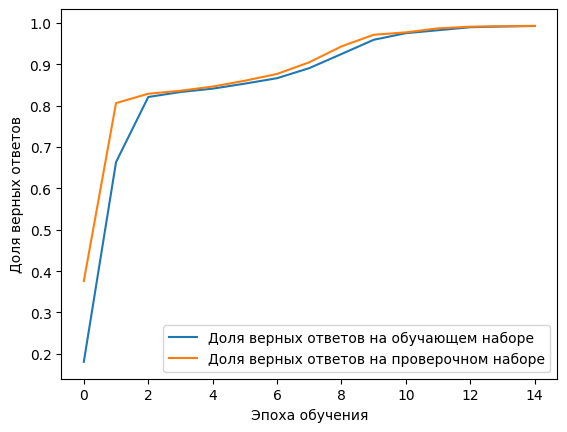

In [ ]:
# Выводим график точности на обучающей выборке
# label - имя графика в легенде
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Выводим график точности на проверочной выборке
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Выводим подписи осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Выводим легенду
plt.legend()
plt.show()

In [ ]:
# Графическое представление результатов работы нейросети
#~~~~~~~~~~~~~~~~~~~~~~~~
def printNNChart(history_n):
  '''
    Отображенние на графике результатов работы нейронной сети (Neural Network)
    вход:
        history_n: массив результатов работы нейросети
  '''
  # Создание полотна для рисунка
  plt.figure(figsize=(18,5))

  # Задание первой (левой) области для построения графиков
  plt.subplot(1, 2, 1)
  # Отрисовка графиков 'loss' и 'val_loss' из значений словаря history.history
  plt.plot(history_n.history['loss'],
           color='blue',
           label = 'Значение ошибки на обучающем наборе')
  plt.plot(history_n.history['val_loss'],
           color='red',
           label = 'Значение ошибки на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Значение ошибки')
  plt.legend()
  plt.grid(which = 'major', color = 'black', alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

  # Задание второй (правой) области для построения графиков
  plt.subplot(1, 2, 2)
  # Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря history.history
  plt.plot(history_n.history['accuracy'],
           color='blue',
           label = 'Доля верных ответов на обучающем наборе')
  plt.plot(history_n.history['val_accuracy'],
           color='red',
           label = 'Доля верных ответов на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.grid(which = 'major', color = 'black', alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

  # Фиксация графиков и рисование всей картинки
  plt.show()

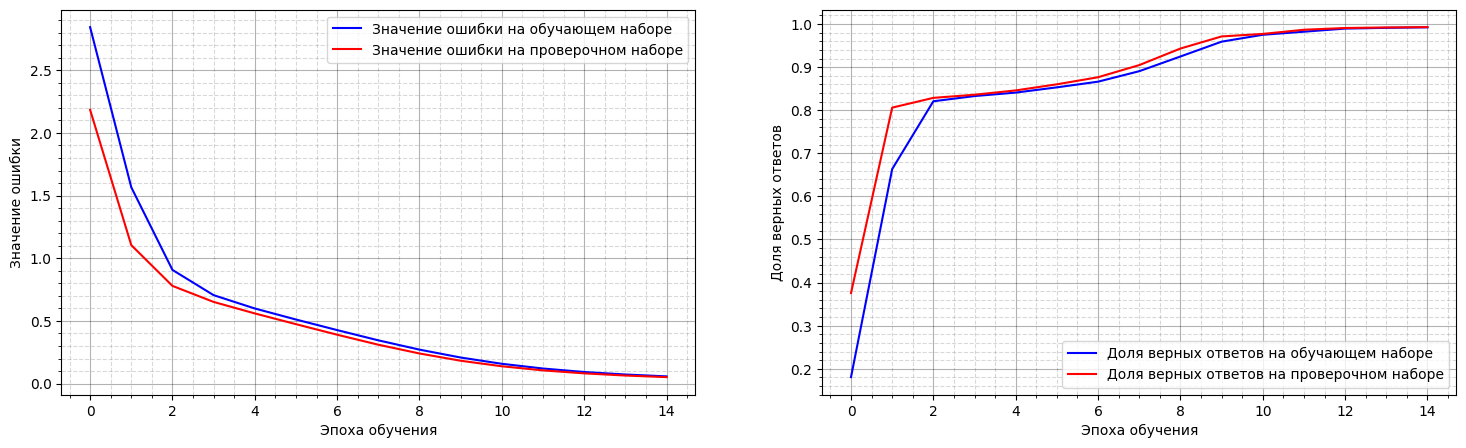

In [ ]:
# Отобразим результаты на графике
printNNChart(history)

In [ ]:
# Запишем модель на локальный disk
model_den.save('/content/drive/MyDrive/Stag_2/model_den.keras')


In [ ]:
# Читаем обученую по заключениям эксперта Ден модель (model_den) с локального diskа в NB
model_den = keras.models.load_model('/content/drive/MyDrive/Stag_2/model_den.keras')

## Проверяем качество обучения на тестовом наборе данных

In [ ]:
# Вычисляем результаты сети на тестовом наборе
scores = model_den.evaluate(x_test, y_test, verbose=1)

# scores состоит из двух знанчений
# scores[0] - loss сети на тестовой выборке
# scores[1] - процент правильно распознанных примеров на тестовой выборке
print(scores)
print("Доля верных ответов на тестовых данных, в процентах: ", round(scores[1] * 100, 4), "%", sep="")

922/922 [==============================] - 2s 2ms/step - loss: 0.0526 - accuracy: 0.9926
[0.05255947634577751, 0.9925742745399475]
Доля верных ответов на тестовых данных, в процентах: 99.2574%


## Проверка единичных вариантов запроса

### Сравним y_pred_n и y_test_n

In [ ]:
q = 1230
x = x_test[q,:]             # читаем элемент из x_test
print('Размерость переменной из xlt_test', x.shape)                 # размерость переменной из x_test
x = np.expand_dims (x, axis=0) # приводим размерность в соответствие с форматом input_dim (n,79)
print('Новая размерость переменной',x.shape)
print('Подаем вектор на вход сети')
n_test_den = model_den.predict (x, verbose=0)  # Распознаём наш пример
print('Размерность полученного ответа',n_test_den.shape)
print('Выходной вектор:')
print(n_test_den, '\n')

# Подадим полученный на выходе сети вектор на дополнительную функцию активации "порог"
#print('Выходной вектор после функции активации "порог', '\n')
#y_pred = []
y_true = n_test_den
w_4567 = np.argmax(y_true)
#w_4567 = porog (y_true)
#w_4567 = np.reshape (w_4567, (17,))
#print('\n','Размерность вектора y_pred_n', w_4567.shape)
print('Предсказанный сеткой ответ y_pred_n -', w_4567)

print('Правильный ответ на запрос с номером n из y_test', y_test[q,:])

#print('Результат сравнения y_pred_n и  y_test_n', '\n')
#print(np.greater_equal(w_4567, y_test[q,:]))

Размерость переменной из xlt_test (40,)
Новая размерость переменной (1, 40)
Подаем вектор на вход сети
Размерность полученного ответа (1, 26)
Выходной вектор:
[[7.8468705e-03 8.0666740e-07 1.1854123e-01 2.0537188e-07 8.9834129e-10
  9.8441517e-01 9.3597502e-01 4.5061268e-02 5.4922937e-05 9.5582206e-04
  8.3075017e-03 1.9130898e-08 3.9791044e-02 1.3810238e-01 5.6706168e-02
  8.4764373e-09 7.8798639e-06 2.4504227e-20 9.6277354e-08 1.7493070e-04
  1.3835297e-12 2.2193879e-08 4.3307046e-12 1.3655340e-07 5.2711759e-05
  1.1339939e-11]] 

Предсказанный сеткой ответ y_pred_n - 5
Правильный ответ на запрос с номером n из y_test [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


### Расшифруем y_pred

#### Подготовим необходимые переменные для расшифровки

In [ ]:
just_row_den = [0,3,8,12,14,16,18,22,31]                                        # обозначим позицыи с которых начинается новый столбец в выходном векторе
y_list_dist_den = list_dist[-8:]  # list_dist формируется функцией perevod          # из списка словарей возьмем 8-мь последних относящихся к Y
y_list_dist_den

[{'одномоментная ХЛТ': 1,
  'последовательная ХЛТ': 2,
  'Симптоматическая терапия': 0},
 {'Этопозид цисплатин/карбоплатин Дурвалумаб': 2,
  'Этопозид цисплатин': 1,
  'пеметрексед+цисплатин': 3,
  'этопозид+цисплатин': 4,
  0: 0},
 {'паклитаксел+карбоплатин': 2,
  'этопозид карбоплатин': 3,
  'еженедельный паклитаксел+ карбоплатин': 1,
  0: 0},
 {True: 1, False: 0},
 {False: 0, True: 1},
 {False: 0, True: 1},
 {0: 0,
  'последовательная ХЛТ': 3,
  'Лучевая терапия в монорежиме': 1,
  'Симпоматическая терапия': 2},
 {'Необходима консультация хирурга на предмет возможного удаления паренхиматозного очага распада. Если невозможно - тщательная оценка риска кровотечения перед началом лучевой терапии': 6,
  0: 0,
  'Необходима более детальная оценка сопутствующей патологии и чем именно обусловлен статус по шкале ECOG 2. Если основным заболеванием, то предпочтение отдаем одновременной ХЛТ, если все-таки тяжесть состояния обусловлена сопутсвующей патологией, то возможно выбрать последовательны

In [ ]:
y_list_den = nmic_xlt_list[11:]   # из списка названий столбцов, возьмем с 11-го до последнего, относящихся к Y
y_list_den

['Ответ эксперта (Ден)',
 'Вариант ХТ',
 'Альтернативный выбор ХТ (как компонента ХЛТ)',
 'Поставьте галочку, если уверены на 100%',
 'Если 75%',
 'Если 50%',
 'Альтернатива, если 50% - обязательно',
 'Комментарий']

#### Функция расшифровки выходного вектора

In [ ]:
def dekoder_den (q, dist_y_den, w_4567, y_list_dist_den, y_list_den, just_row_den ):
  #str_map = dist_y[np.argmax(w_4567)]
  print('w_4567', w_4567)
  str_map = dist_y_den[w_4567]
  sir = []
  o = 0
  kop = {}
  w = []

  for a in range (len(just_row_den)-1):    # цыкл разбора выходного вектора по столбцам
    st = just_row_den[a]
    sp = just_row_den[a+1]
    sir.append(str_map[st:sp])
  print('sir', sir)
  print('q', q, '\n')
  #print('len', len(sir))

  for i in range(len(sir)):     # цыкл перевода содержимого столбца в виде one_hot в цыфровой вид
  #print(len(sir[i]))
    sir_i = sir[i]
    #print(sir_i)

    ch = len(sir[i])-1
    #print(len(sir[i]))

    for k in range(len(sir[i])):
      #print('ch', ch)
      #print(sir[i][k])
      if int(sir [i][k]) == 1:
      #print('wwwwwwwwwwwwww',w)
        w.append(ch)
        #print('w',w)
      ch = ch - 1
#print('Выходной вектор n_test в цыфровом формате по всем столбцам', w)

  for o in range(len(w)):
    #y_list_dist[o]                                    # из списка словарей вытаскиваем очередной словарь
    kop = {v:k for k, v in y_list_dist_den[o].items()}   # инвертируем словарь ключ\значение значение /ключ
    #print(kop)

    print(y_list_den[o], ':', kop[w[o]])

  return


In [ ]:
dekoder_den (q, dist_y_den, w_4567, y_list_dist_den, y_list_den, just_row_den )

w_4567 5
sir ['001', '00001', '0010', '01', '10', '10', '1000', '100000000']
q 1230 

Ответ эксперта (Ден) : Симптоматическая терапия
Вариант ХТ : 0
Альтернативный выбор ХТ (как компонента ХЛТ) : еженедельный паклитаксел+ карбоплатин
Поставьте галочку, если уверены на 100% : False
Если 75% : True
Если 50% : True
Альтернатива, если 50% - обязательно : последовательная ХЛТ
Комментарий : требуется дополнительная оценка статуса пациента, консультация хирурга для решения вопроса о возможной санации с последующим решением вопроса о химиотерапии. При невозможности коррекции общего состояния, рассмотреть вопрос о симптоматической терапии
